In [1]:
import pandas as pd
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import nuts
import settings
import plots

In [2]:
nuts_table = nuts.get_nuts_candidates()

In [3]:
refareas = pd.read_csv(settings.REFERENCE_AREAS_PATH, index_col='geo')
refareas

,A,B,C
geo,,,
AT,2.72689,2.72361,2.28822
AT1,1.09884,1.09803,1.08506
AT11,0.18197,0.18176,0.17671
AT12,0.90885,0.90831,0.90100
AT13,0.00802,0.00796,0.00735
...,...,...,...
UKM3,0.79834,0.79709,0.48694
UKM5,0.47877,0.47753,0.31144
UKM6,2.76356,2.75949,0.43391


In [4]:
harvest = pd.read_csv(settings.HARVEST_PATH, index_col='geo')
harvest

,A,B,C
geo,,,
AT,34.804516,34.805917,31.350676
AT1,15.746320,15.747549,15.658736
AT11,2.426149,2.426345,2.399112
AT12,13.897044,13.897493,13.842071
AT13,0.096793,0.096960,0.095506
...,...,...,...
UKM3,13.674896,13.678676,8.395228
UKM5,8.384508,8.390864,5.601015
UKM6,47.169708,47.172489,7.505728


In [5]:
excretion = pd.read_csv(settings.EXCRETION_PATH, index_col='geo')
excretion

,excretion
geo,
AT,20.597748
AT11,0.274544
AT12,4.484688
AT13,0.000571
AT21,1.753151
...,...
UKM2,5.547687
UKM3,6.966479
UKM5,2.448893


In [6]:
mineral = pd.read_csv(settings.MINERAL_FERTILIZER_PATH, index_col='geo')
mineral

,mineral
geo,
AT,14.234000
AT1,5.735799
AT11,1.106000
AT12,6.595000
AT13,0.041863
...,...
UKM3,3.771635
UKM5,2.261876
UKM6,13.056016


In [7]:
def country_sum_on_level(d, nuts_level):
    return (
        d
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(nuts_table.country_code)
        .groupby('country_code')
        .sum()
    )

In [8]:
terms = (
    pd.DataFrame(
        dict(
            mineral=mineral.mineral,
            excretion=excretion.excretion,
            harvest=-harvest.A
        )
    )
    .rename_axis('geo')
    .rename_axis('term', axis=1)
    .stack()
    .pipe(nuts.fill_nuts)
    .unstack()
)
terms

term,excretion,harvest,mineral
geo,,,
AT,20.597748,-34.804516,14.234000
AT1,4.759803,-15.746320,5.735799
AT11,0.274544,-2.426149,1.106000
AT12,4.484688,-13.897044,6.595000
AT13,0.000571,-0.096793,0.041863
...,...,...,...
UKM3,6.966479,-13.674896,3.771635
UKM5,2.448893,-8.384508,2.261876
UKM6,2.961133,-47.169708,13.056016


In [9]:
terms.loc['DK':'DKX'].div(refareas.A, axis=0).dropna()

term,excretion,harvest,mineral
geo,,,
DK,18.448781,-21.657467,4.695839
DK0,18.447463,-21.758593,4.695839
DK01,10.457256,-20.485670,4.695840
DK02,8.117368,-21.863573,4.695840
DK03,21.027500,-22.332627,4.695839
DK04,20.351103,-21.114465,4.695840
DK05,22.854133,-21.595710,4.695840


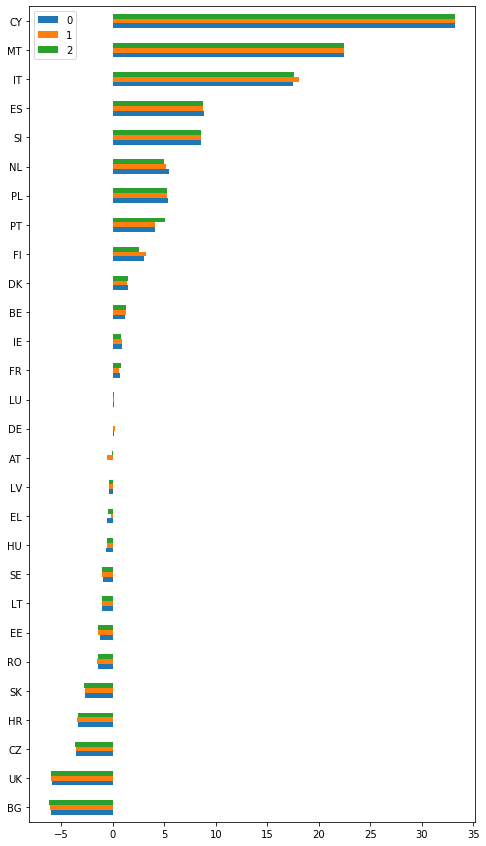

In [12]:
nuts_levels = [0, 1, 2]
national_surplus = pd.DataFrame(
    {
        l: terms.pipe(country_sum_on_level, l).sum(axis=1).div(refareas.A, axis=0).dropna()
        for l in nuts_levels
    }
)
national_surplus.stack().drop(('DE', 2)).unstack().sort_values(0).plot.barh(figsize=(8, 15))
